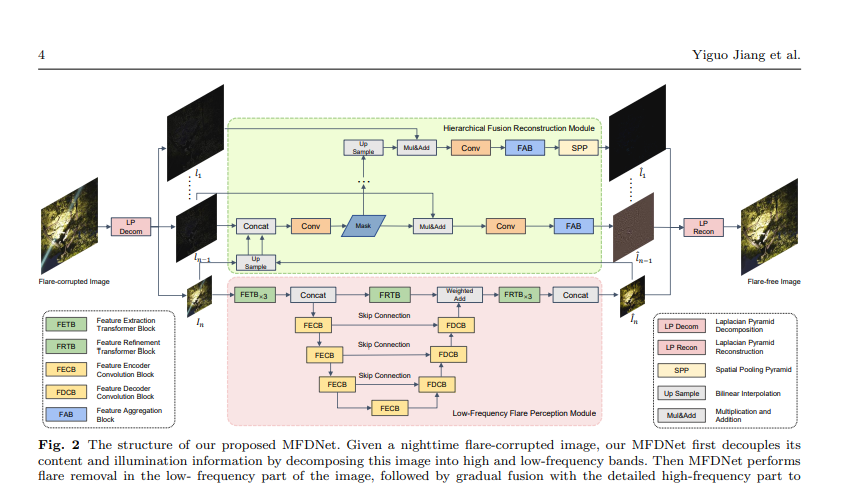


In [ ]:
!pip install gdown

In [ ]:
import gdown

# Replace with your actual Google Drive file ID
file_id = '1JTtQzsF6stWr1M0tuTez-zPBgkQ4BPVr'

# Construct the Google Drive download URL
url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Download the file and save it as a .zip file
gdown.download(url, 'downloaded_file.zip', quiet=False)

# Replace with your actual Google Drive file ID
file_id = '17l2VSxrdQ-PKlkZvzD6qvODgcKtlnlVr'

# Construct the Google Drive download URL
url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Download the file and save it as a .zip file
gdown.download(url, 'downloaded_file.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1JTtQzsF6stWr1M0tuTez-zPBgkQ4BPVr
From (redirected): https://drive.google.com/uc?export=download&id=1JTtQzsF6stWr1M0tuTez-zPBgkQ4BPVr&confirm=t&uuid=75a30304-80e8-474f-938b-01ebefaeceff
To: /content/downloaded_file.zip
100%|██████████| 1.94G/1.94G [00:56<00:00, 34.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=17l2VSxrdQ-PKlkZvzD6qvODgcKtlnlVr
From (redirected): https://drive.google.com/uc?export=download&id=17l2VSxrdQ-PKlkZvzD6qvODgcKtlnlVr&confirm=t&uuid=82051580-d81b-4c30-a413-6a0e4779e8c6
To: /content/downloaded_file.zip
100%|██████████| 2.13G/2.13G [00:57<00:00, 37.1MB/s]


'downloaded_file.zip'

# Libraries

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Model creation

## Lap Pyr

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class LaplacianPyramid():
    def __init__(self, levels, kernel_size=5, sigma=1.0):
        self.levels = levels
        self.gaussian_blur = self.gaussian_kernel(kernel_size, sigma)

    def gaussian_kernel(self, kernel_size=5, sigma=1.0):
        kernel = torch.tensor([[1., 4., 6., 4., 1],
                               [4., 16., 24., 16., 4.],
                               [6., 24., 36., 24., 6.],
                               [4., 16., 24., 16., 4.],
                               [1., 4., 6., 4., 1.]]).to(device)
        kernel /= 256.  # Normalize kernel
        return kernel.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

    def gaussian_blur_fn(self, x):
        kernel_expanded = self.gaussian_blur.expand(x.shape[1], -1, -1, -1).to(device)
        return F.conv2d(x, kernel_expanded, padding=2, groups=x.shape[1])

    def decompose(self, image):
        components = []
        current = image
        for _ in range(self.levels - 1):
            blurred = self.gaussian_blur_fn(current)  # Apply Gaussian blur
            downsampled = F.interpolate(blurred, scale_factor=0.5, mode='bilinear', align_corners=False)
            upsampled = F.interpolate(downsampled, size=current.shape[-2:], mode='bilinear', align_corners=False)
            laplacian = current - upsampled
            components.append(laplacian)
            current = downsampled
        return components, current

    def reconstruct(self, components, low_freq):
        current = low_freq
        for component in reversed(components):
            upsampled = F.interpolate(current, size=component.shape[-2:], mode='bilinear', align_corners=False)
            current = upsampled + component
        return current



## FAB

In [ ]:


class FAB(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(FAB, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=1)
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)
        self.sigmoid = nn.Sigmoid()
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=1)

    def forward(self, x):
        conv_out = self.conv1(x)
        pooled = self.pooling(conv_out)
        pooled = torch.flatten(pooled, 1)
        fc_out = self.fc1(pooled)
        fc_out = self.relu(fc_out)
        fc_out = self.fc2(fc_out)
        scale = self.sigmoid(fc_out).unsqueeze(-1).unsqueeze(-1)  # Reshape to (batch, channels, 1, 1)

        scaled_features = conv_out * scale
        output = self.conv2(scaled_features)

        return output

''' Tryouts: Reflective padding, leaky relu in conv'''


' Tryouts: Reflective padding, leaky relu in conv'

## SPP

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SPP(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers=4, interpolation_type='bilinear'):
        super(SPP, self).__init__()
        self.num_layers = num_layers
        self.interpolation_type = interpolation_type

        self.convs = nn.ModuleList([nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1) for _ in range(self.num_layers)])

        self.fusion = nn.Conv2d(in_channels * (self.num_layers + 1), out_channels, kernel_size=3, stride=1, padding = 1)

    def forward(self, x):
        N, C, H, W = x.size()
        out = []

        for level in range(self.num_layers):
            pooled = F.avg_pool2d(x, kernel_size=2 * 2 ** (level + 1), stride=2 * 2 ** (level + 1),
                                  padding=2 * 2 ** (level + 1) % 2)
            conv_out = self.convs[level](pooled)
            resized_out = F.interpolate(conv_out, size=(H, W), mode=self.interpolation_type)
            out.append(resized_out)

        out.append(x)

        return self.fusion(torch.cat(out, dim=1))

## FETB, FRTB blocks

Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pdb import set_trace as stx
import numbers

import einops
from einops import rearrange
import numpy as np

Layer Norm

In [ ]:
def to_3d(x):
    return rearrange(x, 'b c h w -> b (h w) c')

def to_4d(x,h,w):
    return rearrange(x, 'b (h w) c -> b c h w',h=h,w=w)

In [ ]:
class BiasFree_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(BiasFree_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        sigma = x.var(-1, keepdim=True, unbiased=False)
        print (torch.sqrt(sigma))
        return x / torch.sqrt(sigma+1e-5) * self.weight



In [ ]:
class WithBias_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(WithBias_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        mu = x.mean(-1, keepdim=True)
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return (x - mu) / torch.sqrt(sigma+1e-5) * self.weight + self.bias

In [ ]:

class LayerNorm(nn.Module):
    def __init__(self, dim, LayerNorm_type):
        super(LayerNorm, self).__init__()
        if LayerNorm_type =='BiasFree':
            self.body = BiasFree_LayerNorm(dim)
        else:
            self.body = WithBias_LayerNorm(dim)

    def forward(self, x):
        h, w = x.shape[-2:]
        return to_4d(self.body(to_3d(x)), h, w)

Axis Based Multi - Head Self Attention

In [ ]:
class NextAttentionImplZ(nn.Module):
    def __init__(self, num_dims, num_heads, bias) -> None:
        super().__init__()
        self.num_dims = num_dims
        self.num_heads = num_heads
        self.q1 = nn.Conv2d(num_dims, num_dims * 3, kernel_size=1, bias=bias)
        self.q2 = nn.Conv2d(num_dims * 3, num_dims * 3, kernel_size=3, padding=1, groups=num_dims * 3, bias=bias)
        self.q3 = nn.Conv2d(num_dims * 3, num_dims * 3, kernel_size=3, padding=1, groups=num_dims * 3, bias=bias)

        self.fac = nn.Parameter(torch.ones(1))
        self.fin = nn.Conv2d(num_dims, num_dims, kernel_size=1, bias=bias)
        return

    def forward(self, x):
        # x: [n, c, h, w]
        n, c, h, w = x.size()
        n_heads, dim_head = self.num_heads, c // self.num_heads
        reshape = lambda x: einops.rearrange(x, "n (nh dh) h w -> (n nh h) w dh", nh=n_heads, dh=dim_head)

        qkv = self.q3(self.q2(self.q1(x)))
        q, k, v = map(reshape, qkv.chunk(3, dim=1))
        q = F.normalize(q, dim=-1)
        k = F.normalize(k, dim=-1)

        # fac = dim_head ** -0.5
        res = k.transpose(-2, -1)
        res = torch.matmul(q, res) * self.fac
        res = torch.softmax(res, dim=-1)

        res = torch.matmul(res, v)
        res = einops.rearrange(res, "(n nh h) w dh -> n (nh dh) h w", nh=n_heads, dh=dim_head, n=n, h=h)
        res = self.fin(res)

        return res

Axis-based Multi-head Self-Attention (row and col attention)

In [ ]:
class NextAttentionZ(nn.Module):
    def __init__(self, num_dims, num_heads=1, bias=True) -> None:
        super().__init__()
        assert num_dims % num_heads == 0
        self.num_dims = num_dims
        self.num_heads = num_heads
        self.row_att = NextAttentionImplZ(num_dims, num_heads, bias)
        self.col_att = NextAttentionImplZ(num_dims, num_heads, bias)
        return

    def forward(self, x: torch.Tensor):
        assert len(x.size()) == 4

        x = self.row_att(x)
        x = x.transpose(-2, -1)
        x = self.col_att(x)
        x = x.transpose(-2, -1)

        return x

Dual Gated Feed-Forward Network

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, dim, ffn_expansion_factor, bias):
        super(FeedForward, self).__init__()

        hidden_features = int(dim*ffn_expansion_factor)

        self.project_in = nn.Conv2d(dim, hidden_features*2, kernel_size=1, bias=bias)

        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2, bias=bias)

        self.project_out = nn.Conv2d(hidden_features, dim, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.project_in(x)
        x1, x2 = self.dwconv(x).chunk(2, dim=1)
        x = F.gelu(x2)*x1 + F.gelu(x1)*x2
        x = self.project_out(x)
        return x

FETB and FRTB blocks

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads=1, ffn_expansion_factor=2.66, bias=True, LayerNorm_type='WithBias'):
        super(TransformerBlock, self).__init__()
        """dim refers to number of channels in each image
           as normalization is over the channel dimension"""
        self.norm1 = LayerNorm(dim, LayerNorm_type)
        self.attn = NextAttentionZ(dim, num_heads)
        self.norm2 = LayerNorm(dim, LayerNorm_type)
        self.ffn = FeedForward(dim, ffn_expansion_factor, bias)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x



In [ ]:
block = TransformerBlock (3)

In [ ]:
img = torch.rand ((4, 3, 64, 64))

output = block (img)

print (output.shape)

torch.Size([4, 3, 64, 64])


## FDCB, FECB

In [ ]:

import math
import torch
from torch import nn as nn
from torch.nn import functional as F
from torch.nn import init as init
from torch.nn.modules.batchnorm import _BatchNorm

class LayerNormFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, weight, bias, eps):
        ctx.eps = eps
        N, C, H, W = x.size()
        mu = x.mean(1, keepdim=True)
        var = (x - mu).pow(2).mean(1, keepdim=True)
        y = (x - mu) / (var + eps).sqrt()
        ctx.save_for_backward(y, var, weight)
        y = weight.view(1, C, 1, 1) * y + bias.view(1, C, 1, 1)
        return y

    @staticmethod
    def backward(ctx, grad_output):
        eps = ctx.eps

        N, C, H, W = grad_output.size()
        y, var, weight = ctx.saved_variables
        g = grad_output * weight.view(1, C, 1, 1)
        mean_g = g.mean(dim=1, keepdim=True)

        mean_gy = (g * y).mean(dim=1, keepdim=True)
        gx = 1. / torch.sqrt(var + eps) * (g - y * mean_gy - mean_g)
        return gx, (grad_output * y).sum(dim=3).sum(dim=2).sum(dim=0), grad_output.sum(dim=3).sum(dim=2).sum(
            dim=0), None

class LayerNorm2d(nn.Module):

    def __init__(self, channels, eps=1e-6):
        super(LayerNorm2d, self).__init__()
        self.register_parameter('weight', nn.Parameter(torch.ones(channels)))
        self.register_parameter('bias', nn.Parameter(torch.zeros(channels)))
        self.eps = eps

    def forward(self, x):
        return LayerNormFunction.apply(x, self.weight, self.bias, self.eps)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class SimpleGate(nn.Module):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        return x1 * x2

class NAFBlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2, drop_out_rate=0.):
        super().__init__()
        dw_channel = c * DW_Expand
        self.conv1 = nn.Conv2d(in_channels=c, out_channels=dw_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=dw_channel, out_channels=dw_channel, kernel_size=3, padding=1, stride=1, groups=dw_channel,
                               bias=True)
        self.conv3 = nn.Conv2d(in_channels=dw_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        # Simplified Channel Attention
        self.sca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels=dw_channel // 2, out_channels=dw_channel // 2, kernel_size=1, padding=0, stride=1,
                      groups=1, bias=True),
        )

        # SimpleGate
        self.sg = SimpleGate()

        ffn_channel = FFN_Expand * c
        self.conv4 = nn.Conv2d(in_channels=c, out_channels=ffn_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=ffn_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        self.norm1 = LayerNorm2d(c)
        self.norm2 = LayerNorm2d(c)

        self.dropout1 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()
        self.dropout2 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()

        self.beta = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)
        self.gamma = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)

    def forward(self, inp):
        x = inp

        x = self.norm1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.sg(x)
        x = x * self.sca(x)
        x = self.conv3(x)

        x = self.dropout1(x)

        y = inp + x * self.beta

        x = self.conv4(self.norm2(y))
        x = self.sg(x)
        x = self.conv5(x)

        x = self.dropout2(x)

        return y + x * self.gamma


class NAFNet(nn.Module):

    def __init__(self, img_channel=3, width=32, middle_blk_num=1, enc_blk_nums=[], dec_blk_nums=[]):
        super().__init__()

        self.intro = nn.Conv2d(in_channels=img_channel, out_channels=width, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True)
        self.ending = nn.Conv2d(in_channels=width, out_channels=img_channel, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True)

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.middle_blks = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()

        chan = width
        for num in enc_blk_nums:
            self.encoders.append(
                nn.Sequential(
                    *[NAFBlock(chan) for _ in range(num)]
                )
            )
            self.downs.append(
                nn.Conv2d(chan, 2*chan, 2, 2)
            )
            chan = chan * 2

        self.middle_blks = \
            nn.Sequential(
                *[NAFBlock(chan) for _ in range(middle_blk_num)]
            )

        for num in dec_blk_nums:
            self.ups.append(
                nn.Sequential(
                    nn.Conv2d(chan, chan * 2, 1, bias=False),
                    nn.PixelShuffle(2)
                )
            )
            chan = chan // 2
            self.decoders.append(
                nn.Sequential(
                    *[NAFBlock(chan) for _ in range(num)]
                )
            )

        self.padder_size = 2 ** len(self.encoders)

    def forward(self, inp):
        B, C, H, W = inp.shape
        inp = self.check_image_size(inp)

        x = self.intro(inp)

        encs = []

        for encoder, down in zip(self.encoders, self.downs):
            x = encoder(x)
            encs.append(x)
            x = down(x)

        x = self.middle_blks(x)

        for decoder, up, enc_skip in zip(self.decoders, self.ups, encs[::-1]):
            x = up(x)
            x = x + enc_skip
            x = decoder(x)

        x = self.ending(x)
        x = x + inp

        return x[:, :, :H, :W]

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.padder_size - h % self.padder_size) % self.padder_size
        mod_pad_w = (self.padder_size - w % self.padder_size) % self.padder_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h))
        return x

if __name__ == '__main__':
    img_channel = 3
    width = 32

    # enc_blks = [2, 2, 4, 8]
    # middle_blk_num = 12
    # dec_blks = [2, 2, 2, 2]

    enc_blks = [1, 1, 1, 28]
    middle_blk_num = 1
    dec_blks = [1, 1, 1, 1]

    net = NAFNet(img_channel=img_channel, width=width, middle_blk_num=middle_blk_num,
                      enc_blk_nums=enc_blks, dec_blk_nums=dec_blks)




In [ ]:
    inp_shape = (3, 64, 64)
    res=net(torch.randn(10, *inp_shape))
    print(res.shape)

torch.Size([10, 3, 64, 64])


## LAM, weightage addition

In [ ]:
#concat shit
class LAM_Module_v2(nn.Module):
    """ Layer attention module"""
    def __init__(self, in_dim ,bias=True):
        super().__init__()
        self.chanel_in = in_dim

        self.temperature = nn.Parameter(torch.ones(1))

        self.qkv = nn.Conv2d( self.chanel_in ,  self.chanel_in *3, kernel_size=1, bias=bias)
        self.qkv_dwconv = nn.Conv2d(self.chanel_in*3, self.chanel_in*3, kernel_size=3, stride=1, padding=1, groups=self.chanel_in*3, bias=bias)
        self.project_out = nn.Conv2d(self.chanel_in, self.chanel_in, kernel_size=1, bias=bias)
        self.size_match = nn.Conv2d( self.chanel_in ,  self.chanel_in // 3, kernel_size=1, bias=bias)

    def forward(self,x):
        m_batchsize, N, C, height, width = x.size()

        x_input = x.view(m_batchsize,N*C, height, width)
        qkv = self.qkv_dwconv(self.qkv(x_input))
        q, k, v = qkv.chunk(3, dim=1)
        q = q.view(m_batchsize, N, -1)
        k = k.view(m_batchsize, N, -1)
        v = v.view(m_batchsize, N, -1)

        q = torch.nn.functional.normalize(q, dim=-1)
        k = torch.nn.functional.normalize(k, dim=-1)

        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)

        out_1 = (attn @ v)
        out_1 = out_1.view(m_batchsize, -1, height, width)

        out_1 = self.project_out(out_1)
        out_1 = out_1.view(m_batchsize, N, C, height, width)

        out = out_1+x
        out = out.view(m_batchsize, -1, height, width)
        out = self.size_match (out)
        return out

In [ ]:
#weighted add shit
class WeightedAdditionModel(nn.Module):
    def __init__(self):
        super(WeightedAdditionModel, self).__init__()
        # Initialize alpha as a trainable parameter
        self.alpha = nn.Parameter(torch.tensor(0.5))  # Start with a value like 0.5

    def forward(self, image1, image2):
        # Perform weighted addition
        weighted_sum = self.alpha * image1 + (1 - self.alpha) * image2
        return weighted_sum



## LFFPM module

In [ ]:
class LFFPM(nn.Module):
    def __init__(self):
        super().__init__()
        self.FETB = TransformerBlock(dim=3)
        self.attention_module = LAM_Module_v2(9)
        self.nafnet = NAFNet(img_channel=3, width=32, middle_blk_num=1, enc_blk_nums=[1, 1, 1, 28], dec_blk_nums=[1, 1, 1, 1])
        self.weighted_addition = WeightedAdditionModel()

    def FETB_concat(self, x):
        x1 = self.FETB(x)
        x2 = self.FETB(x1)
        x3 = self.FETB(x2)
        x = torch.cat((x1.unsqueeze(dim=1), x2.unsqueeze(dim=1), x3.unsqueeze(dim=1)), dim=1)
        return x

    def forward(self,In):
        x = self.FETB_concat(In)
        result = self.attention_module(x)
        x_refined = self.FETB(result)
        x_out = self.nafnet(result)
        x_weighted_add = self.weighted_addition(x_out, x_refined)
        x_final =self.attention_module(self.FETB_concat(x_weighted_add))
        return x_final

if __name__ == "__main__":
    image_tensor = torch.rand(1, 3, 256, 256)
    pipeline = LFFPM()
    output = pipeline(image_tensor)
    print("Final output shape:", output.shape)


Final output shape: torch.Size([1, 3, 256, 256])


## HFRM module

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HFRM(nn.Module):
    def __init__(self, num_channels):
        super(HFRM, self).__init__()

        self.fab = FAB(in_channels=num_channels)

        self.spp = SPP(in_channels=num_channels, out_channels=num_channels)

        self.conv_layer_mask = nn.Sequential(
            nn.Conv2d(9, 3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, components, low_level):
        In, In_prime = low_level
        n = len(components) + 1
        result = []

        # Initial upsample of In and In'
        In_upsampled= F.interpolate(In, scale_factor=2, mode='bilinear', align_corners=False)
        In_prime_upsampled = F.interpolate(In_prime, scale_factor=2, mode='bilinear', align_corners=False)
        concat_features = torch.cat([components[-1], In_upsampled, In_prime_upsampled], dim=1)
        # Pass through the convolution layer
        mask = self.conv_layer_mask(concat_features)
        # print("mask",mask.shape)
        for i in range(n - 2, - 1, -1):

            Ii = components[i]
            #print(f"{i} Ii shape",Ii.shape)
            Ii_prime = mask * Ii + Ii
            Ii_prime = self.conv_layer(Ii_prime)
            Ii_prime = self.fab(Ii_prime)
            #print(f"{i} Iiprime shape",Ii_prime.shape)

            if i == 0:
                Ii_prime = self.spp(Ii_prime)
            result.append(Ii_prime)
            if i > 0:
                mask = F.interpolate(mask, scale_factor=2, mode="bilinear", align_corners=False)

        return result

# MODEL

In [ ]:
class MFDNet(nn.Module):
  def __init__(self, levels = 4, num_channels = 3):
    super(MFDNet,self).__init__()
    self.lp = LaplacianPyramid(levels = levels)
    self.lffpm = LFFPM()
    self.hfrm = HFRM(num_channels = num_channels)

  def forward(self, x):
    components, In = self.lp.decompose(x)
    #print("After LP decomp", components[0].shape, In.shape)
    In_prime = self.lffpm(In)
    #print("Output of LFFPM", In_prime.shape)
    lowlevel = [In, In_prime]
    result = self.hfrm(components, lowlevel)
    result = result[::-1]
    #print(" Highest frequecny component reconstruction", result[0].shape)
    final_output = self.lp.reconstruct(result, In_prime)
    #print("Final Output shape", final_output.shape)

    return final_output


In [ ]:
image_tensor = torch.rand(1, 3, 512, 512)
pipeline = MFDNet().to(device)
output = pipeline(image_tensor.to(device))
print("Final output shape:", output.shape)

/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Final output shape: torch.Size([1, 3, 512, 512])


In [ ]:
for name, param in pipeline.named_parameters():
    print(name)  # Should only list `fc.weight` and `fc.bias`


lffpm.FETB.norm1.body.weight
lffpm.FETB.norm1.body.bias
lffpm.FETB.attn.row_att.fac
lffpm.FETB.attn.row_att.q1.weight
lffpm.FETB.attn.row_att.q1.bias
lffpm.FETB.attn.row_att.q2.weight
lffpm.FETB.attn.row_att.q2.bias
lffpm.FETB.attn.row_att.q3.weight
lffpm.FETB.attn.row_att.q3.bias
lffpm.FETB.attn.row_att.fin.weight
lffpm.FETB.attn.row_att.fin.bias
lffpm.FETB.attn.col_att.fac
lffpm.FETB.attn.col_att.q1.weight
lffpm.FETB.attn.col_att.q1.bias
lffpm.FETB.attn.col_att.q2.weight
lffpm.FETB.attn.col_att.q2.bias
lffpm.FETB.attn.col_att.q3.weight
lffpm.FETB.attn.col_att.q3.bias
lffpm.FETB.attn.col_att.fin.weight
lffpm.FETB.attn.col_att.fin.bias
lffpm.FETB.norm2.body.weight
lffpm.FETB.norm2.body.bias
lffpm.FETB.ffn.project_in.weight
lffpm.FETB.ffn.project_in.bias
lffpm.FETB.ffn.dwconv.weight
lffpm.FETB.ffn.dwconv.bias
lffpm.FETB.ffn.project_out.weight
lffpm.FETB.ffn.project_out.bias
lffpm.attention_module.temperature
lffpm.attention_module.qkv.weight
lffpm.attention_module.qkv.bias
lffpm.attenti

# training loop

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
import torch.optim as optim
from accelerate import Accelerator
from torch.utils.data import DataLoader
from torchmetrics.functional import peak_signal_noise_ratio, structural_similarity_index_measure
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

from tqdm import tqdm

Loss functions

In [ ]:
criterion_ssim = structural_similarity_index_measure
criterion_psnr = torch.nn.MSELoss().to(device)
criterion_lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex').to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 175MB/s]
/usr/local/lib/python3.11/dist-packages/torchmetrics/functional/image/lpips.py:323: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use

Making a sample input and ground truth batch

loss, optimiser

## Dataset

In [ ]:
#mounting drive

from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
input_size = (512,512)

In [ ]:
import os
import zipfile
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Paths to ZIP files
input_zip_path = '/content/drive/MyDrive/flare dataset/train_input_2k.zip'
gt_zip_path = '/content/drive/MyDrive/flare dataset/train_gt_2k.zip'

# Extract ZIP files
input_dir = '/content/flare_dataset/train_input'
gt_dir = '/content/flare_dataset/train_gt'

os.makedirs(input_dir, exist_ok=True)
os.makedirs(gt_dir, exist_ok=True)


os.makedirs(input_dir, exist_ok=True)
with zipfile.ZipFile(input_zip_path, 'r') as zip_ref:
    zip_ref.extractall(input_dir)


os.makedirs(gt_dir, exist_ok=True)
with zipfile.ZipFile(gt_zip_path, 'r') as zip_ref:
    zip_ref.extractall(gt_dir)

# Custom Dataset Class
class FlareDataset(Dataset):
    def __init__(self, input_dir, gt_dir, transform=None):
        self.input_dir = input_dir
        self.gt_dir = gt_dir
        self.input_images = sorted(os.listdir(input_dir))
        self.gt_images = sorted(os.listdir(gt_dir))
        self.transform = transform

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.input_images[idx])
        gt_path = os.path.join(self.gt_dir, self.gt_images[idx])

        # Load images
        input_image = Image.open(input_path).convert("RGB")
        gt_image = Image.open(gt_path).convert("RGB")

        # Apply transformations
        if self.transform:
            input_image = self.transform(input_image)
            gt_image = self.transform(gt_image)

        return input_image, gt_image

# Define transformations
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])


In [ ]:
bs = 16

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


input_dir = '/content/flare_dataset/train_input/train_input_2k'
gt_dir = '/content/flare_dataset/train_gt/train_gt_2k'


flare_dataset = FlareDataset(input_dir=input_dir, gt_dir=gt_dir, transform=transform)
flare_loader = DataLoader(flare_dataset, batch_size= bs, shuffle=True, num_workers=2)


for inputs, gts in flare_loader:
    print(f"Input batch shape: {inputs.shape}")
    print(f"Ground Truth batch shape: {gts.shape}")
    break


Input batch shape: torch.Size([16, 3, 512, 512])
Ground Truth batch shape: torch.Size([16, 3, 512, 512])


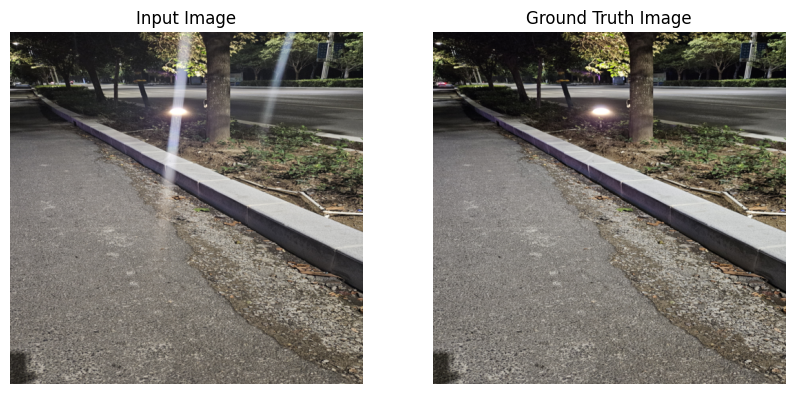

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as Fg

inputs, gts = next(iter(flare_loader))

input_image = inputs[0]
gt_image = gts[0]




input_image_pil = Fg.to_pil_image(input_image)
gt_image_pil = Fg.to_pil_image(gt_image)

# Plot the images
plt.figure(figsize=(10, 5))

# Input image
plt.subplot(1, 2, 1)
plt.imshow(input_image_pil)
plt.title("Input Image")
plt.axis("off")

# Ground truth image
plt.subplot(1, 2, 2)
plt.imshow(gt_image_pil)
plt.title("Ground Truth Image")
plt.axis("off")

plt.show()


## **Training** loop

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])


flare_dataset = FlareDataset(input_dir=input_dir, gt_dir=gt_dir, transform=transform)
flare_loader = DataLoader(flare_dataset, batch_size=bs, shuffle=True, num_workers=2)


for inputs, gts in flare_loader:
    print(f"Input batch shape: {inputs.shape}")
    print(f"Ground Truth batch shape: {gts.shape}")
    break


Input batch shape: torch.Size([16, 3, 512, 512])
Ground Truth batch shape: torch.Size([16, 3, 512, 512])


In [ ]:
len(flare_dataset)

600

In [ ]:
len(flare_loader)

38

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = MFDNet()
model = model.to (device)

/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [ ]:
learning_rate = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
epochs = 10

In [ ]:
for epoch in range(epochs):
    print('\n')
    print(f'Epoch Number {epoch}')
    print('\n')

    epoch_loss = 0
    num_batches = 0

    for batch, (inputs, gts) in enumerate(flare_loader):
        inputs = inputs.to(device)
        gts = gts.to(device)

        # Forward pass
        prediction = model(inputs)

        # Calculate losses
        loss_psnr = criterion_psnr(prediction, gts)
        loss_ssim = 1 - criterion_ssim(prediction, gts, data_range=1)
        loss_lpips = criterion_lpips(prediction.mul(2).sub(
            1).clamp(-1, 1), gts.mul(2).sub(1).clamp(-1, 1))

        train_loss = loss_psnr + 0.3 * loss_ssim + 0.7 * loss_lpips


        epoch_loss += train_loss.item()
        num_batches += 1


        print(f"Train Loss for batch {batch+1}: {train_loss.item()}")


        train_loss.backward()
        optimizer.step()


    avg_epoch_loss = epoch_loss / num_batches
    print(f"\nEpoch {epoch} Average Loss: {avg_epoch_loss}\n")






Epoch Number 0




/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Train Loss for batch 1: 1.4322863817214966


<ipython-input-19-4c9c1e4238ba>:26: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  y, var, weight = ctx.saved_variables


Train Loss for batch 2: 1.3208796977996826
Train Loss for batch 3: 1.2136139869689941
Train Loss for batch 4: 1.0495519638061523
Train Loss for batch 5: 1.05448579788208
Train Loss for batch 6: 1.0251963138580322
Train Loss for batch 7: 0.9977064728736877
Train Loss for batch 8: 1.0309869050979614
Train Loss for batch 9: 1.0223503112792969
Train Loss for batch 10: 1.0213936567306519
Train Loss for batch 11: 1.0506671667099
Train Loss for batch 12: 1.0443967580795288
Train Loss for batch 13: 1.0001026391983032
Train Loss for batch 14: 1.0391911268234253
Train Loss for batch 15: 1.0527722835540771
Train Loss for batch 16: 1.0578296184539795
Train Loss for batch 17: 1.1224877834320068
Train Loss for batch 18: 1.17337167263031
Train Loss for batch 19: 1.1427854299545288
Train Loss for batch 20: 1.06534743309021
Train Loss for batch 21: 1.056847095489502
Train Loss for batch 22: 1.010340929031372
Train Loss for batch 23: 0.9966335892677307
Train Loss for batch 24: 0.9577004909515381
Train L

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a2bdc059620>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 948, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
     

KeyboardInterrupt: 

# Outputs

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as Fg


inputs, gts = next(iter(flare_loader))


input_image = inputs[0]
gt_image = gts[0]

pred = model(input_image.unsqueeze(dim = 0).to(device))


output_pil = Fg.to_pil_image(pred.squeeze())
input_image_pil = Fg.to_pil_image(input_image)
gt_image_pil = Fg.to_pil_image(gt_image)

# Plot the images
plt.figure(figsize=(10, 5))

# Input image
plt.subplot(1, 3, 1)
plt.imshow(input_image_pil)
plt.title("Input Image")
plt.axis("off")

# Ground truth image
plt.subplot(1, 3, 2)
plt.imshow(gt_image_pil)
plt.title("Ground Truth Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(output_pil)
plt.title("Output Image")
plt.axis("off")

plt.show()


#Sample Training Loss


In [ ]:
'''Epoch Number 0


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(
Train Loss for batch 1: 1.670762538909912
<ipython-input-17-4c9c1e4238ba>:26: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  y, var, weight = ctx.saved_variables
Train Loss for batch 2: 1.5723563432693481
Train Loss for batch 3: 1.503454566001892
Train Loss for batch 4: 1.4096348285675049
Train Loss for batch 5: 1.3492741584777832
Train Loss for batch 6: 1.2923578023910522
Train Loss for batch 7: 1.1756463050842285
Train Loss for batch 8: 1.0671199560165405
Train Loss for batch 9: 0.9996415376663208
Train Loss for batch 10: 0.9717759490013123

Epoch 0 Average Loss: 1.3012023985385894



Epoch Number 1


Train Loss for batch 1: 1.2254278659820557
Train Loss for batch 2: 1.3739752769470215
Train Loss for batch 3: 1.1648058891296387
Train Loss for batch 4: 0.9807071685791016
Train Loss for batch 5: 0.8990576863288879
Train Loss for batch 6: 0.8972234129905701
Train Loss for batch 7: 0.911729633808136
Train Loss for batch 8: 0.8967485427856445
Train Loss for batch 9: 0.8995444774627686
Train Loss for batch 10: 0.8753054141998291

Epoch 1 Average Loss: 1.0124525368213653



Epoch Number 2


Train Loss for batch 1: 0.8891798257827759
Train Loss for batch 2: 0.9026907682418823
Train Loss for batch 3: 0.9002748131752014
Train Loss for batch 4: 0.902366042137146
Train Loss for batch 5: 0.8939574956893921
Train Loss for batch 6: 0.9069606065750122
Train Loss for batch 7: 0.9100748300552368
Train Loss for batch 8: 0.9233965277671814
Train Loss for batch 9: 0.9677914381027222
Train Loss for batch 10: 0.9790063500404358

Epoch 2 Average Loss: 0.9175698697566986



Epoch Number 3


Train Loss for batch 1: 0.9997072815895081
Train Loss for batch 2: 1.0934029817581177
Train Loss for batch 3: 1.163240909576416
Train Loss for batch 4: 1.1552948951721191
Train Loss for batch 5: 1.1180925369262695
Train Loss for batch 6: 1.0497702360153198
Train Loss for batch 7: 1.0196785926818848
Train Loss for batch 8: 1.0532104969024658
Train Loss for batch 9: 1.0621495246887207
Train Loss for batch 10: 1.1023237705230713

Epoch 3 Average Loss: 1.0816871225833893



Epoch Number 4


Train Loss for batch 1: 1.7994520664215088
Train Loss for batch 2: 1.0726876258850098
Train Loss for batch 3: 1.046532392501831
Train Loss for batch 4: 1.0748000144958496
Train Loss for batch 5: 1.1434880495071411
Train Loss for batch 6: 1.2323009967803955
Train Loss for batch 7: 1.3844327926635742
Train Loss for batch 8: 1.6451494693756104
Train Loss for batch 9: 1.9231727123260498
Train Loss for batch 10: 2.1322836875915527

Epoch 4 Average Loss: 1.4454299807548523



Epoch Number 5


Train Loss for batch 1: 1.8007900714874268
Train Loss for batch 2: 1.3861119747161865
Train Loss for batch 3: 1.059016466140747
Train Loss for batch 4: 1.252444863319397
Train Loss for batch 5: 1.755366563796997
Train Loss for batch 6: 1.2861859798431396
Train Loss for batch 7: 2.640991687774658
Train Loss for batch 8: 5.22100830078125
Train Loss for batch 9: 3.2928895950317383
Train Loss for batch 10: 1.362809658050537

Epoch 5 Average Loss: 2.1057615160942076



Epoch Number 6


Train Loss for batch 1: 3.271444797515869
Train Loss for batch 2: 8.164600372314453
Train Loss for batch 3: 10.153599739074707
Train Loss for batch 4: 6.2301225662231445
Train Loss for batch 5: 2.4287495613098145
Train Loss for batch 6: 1.2392594814300537
Train Loss for batch 7: 1.204622745513916
Train Loss for batch 8: 2.8092150688171387'''